In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from scipy.sparse import hstack


In [21]:
train_path ="/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
test_path="/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"

# Data Preprocessing

In [22]:
def convertTXTtoCSVFormatforTraining(path):
    """
    Convert a text file with train data format:
    ID ::: TITLE ::: GENRE ::: DESCRIPTION
    into a DataFrame with columns [ID, TITLE, GENRE, DESCRIPTION].
    """

    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            parts = [p.strip() for p in line.split(":::")]
            if len(parts) != 4:
                print(f"Skipping malformed line: {line}")
                continue
            records.append(parts)

    df = pd.DataFrame(records, columns=["ID", "TITLE", "GENRE", "DESCRIPTION"])
    return df
def convertTXTtoCSVFormatforTest(path):
    """
    Convert a text file with test data format:
    ID ::: TITLE ::: DESCRIPTION
    into a DataFrame with columns [ID, TITLE, DESCRIPTION].
    """

    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            parts = [p.strip() for p in line.split(":::")]
            if len(parts) != 3:
                print(f"Skipping malformed line: {line}")
                continue
            records.append(parts)

    df = pd.DataFrame(records, columns=["ID", "TITLE", "DESCRIPTION"])
    return df

In [23]:
train_df = convertTXTtoCSVFormatforTraining(train_path)
test_df = convertTXTtoCSVFormatforTest(test_path)

In [24]:
train_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [25]:
test_df.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...


In [26]:
train_df.info()
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  object
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [27]:
train_df['GENRE'].unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

Unique Genres and Counts:


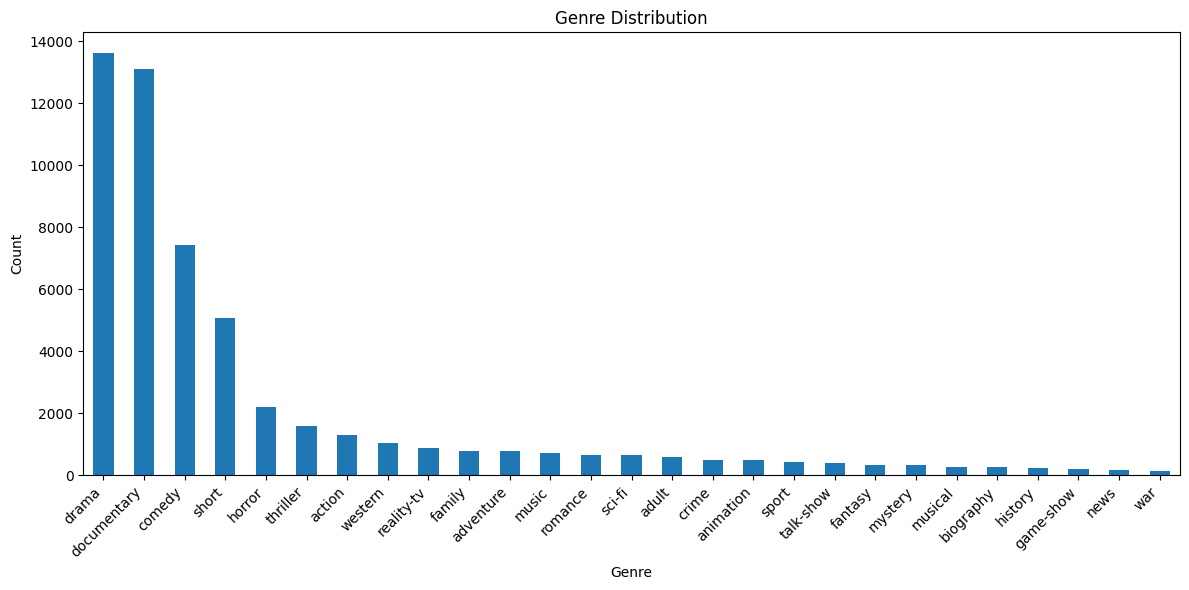

In [28]:
# Count occurrences of each genre
genre_counts = train_df["GENRE"].value_counts().sort_values(ascending=False)

# Print unique genres and counts
print("Unique Genres and Counts:")
#print(genre_counts)

# Plot histogram
plt.figure(figsize=(12,6))
genre_counts.plot(kind="bar")
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [29]:
encoder = LabelEncoder()
y = encoder.fit_transform(train_df['GENRE'])

# TfidfVectorizer

In [30]:
# Suppose df['DESCRIPTION'] contains your movie descriptions
vectorizer = TfidfVectorizer(
    max_features=5000,   # keep top 5000 words
    stop_words='english' # remove common words like 'the', 'and'
)

X_desc = vectorizer.fit_transform(train_df['DESCRIPTION'])
print(X_desc.shape) 

(54214, 5000)


In [31]:
title_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_title = title_vectorizer.fit_transform(train_df['TITLE'])
#Combined X_title and X_desc
X_combined = hstack([X_title, X_desc])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

In [33]:
# Define all classifiers to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

best_acc = 0
best_clf = None
best_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_clf = model
        best_name = name

print("\nBest Classifier:", best_name)
print("Best Accuracy:", best_acc)
y_pred_best = best_clf.predict(X_test)
#print(classification_report(y_test, y_pred_best, target_names=encoder.classes_))

# Use best_clf for future predictions
clf_tfidf = best_clf


Logistic Regression Accuracy: 0.5839
Decision Tree Accuracy: 0.3624
Random Forest Accuracy: 0.4936

Best Classifier: Logistic Regression
Best Accuracy: 0.5838790002766762


# Preidction on Test Dataset by TFIDF

In [34]:
# Description
X_test_desc = vectorizer.transform(test_df['DESCRIPTION'])

# If you used TITLE TF-IDF too:
X_test_title = title_vectorizer.transform(test_df['TITLE'])

X_test_combined = hstack([X_test_title, X_test_desc])


In [35]:
y_pred_test = clf_tfidf.predict(X_test_combined)
y_pred_labels = encoder.inverse_transform(y_pred_test)

test_df['PREDICTED_GENRE'] = y_pred_labels
test_df[['ID', 'TITLE', 'PREDICTED_GENRE']].to_csv("test_predictions_vec.csv", index=False)
test_df.head()

,ID,TITLE,DESCRIPTION,PREDICTED_GENRE
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",short
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...",drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...",drama
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,drama


# Word Embedding Technique

In [36]:
# Prepare corpus: list of tokenized sentences
corpus = [text.lower().split() for text in train_df['DESCRIPTION']]  # only description
corpus += [text.lower().split() for text in train_df['TITLE']]        # include titles too

# Train Word2Vec
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)


In [37]:
def embed_text(text, model):
    words = text.lower().split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [38]:
X_desc_emb = np.array([embed_text(desc, w2v_model) for desc in train_df['DESCRIPTION']])

# TITLE embeddings (optional)
X_title_emb = np.array([embed_text(title, w2v_model) for title in train_df['TITLE']])

# Combine TITLE + DESCRIPTION embeddings
X_combined_emb = np.hstack([X_title_emb, X_desc_emb])

In [39]:

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_combined_emb, y, test_size=0.2, stratify=y, random_state=42
)


In [40]:
best_acc = 0
best_clf = None
best_name = ""

for name, model in models.items():
    model.fit(X_train_emb, y_train_emb)
    y_pred_emb = model.predict(X_test_emb)
    acc = accuracy_score(y_test_emb, y_pred_emb)
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_clf = model
        best_name = name

print("\nBest Classifier:", best_name)
print("Best Accuracy:", best_acc)
y_pred_best = best_clf.predict(X_test_emb)
#print(classification_report(y_test, y_pred_best, target_names=encoder.classes_))
clf_emb = best_clf

Logistic Regression Accuracy: 0.5202
Decision Tree Accuracy: 0.3058
Random Forest Accuracy: 0.4666

Best Classifier: Logistic Regression
Best Accuracy: 0.5201512496541547


# Preidction on Test Dataset by Word Embedding Technique

In [41]:
# --- TEST EMBEDDINGS ---

# DESCRIPTION embeddings
X_test_desc_emb = np.array([embed_text(desc, w2v_model) for desc in test_df['DESCRIPTION']])

# TITLE embeddings
X_test_title_emb = np.array([embed_text(title, w2v_model) for title in test_df['TITLE']])

# Combine TITLE + DESCRIPTION embeddings
X_test_combined_emb = np.hstack([X_test_title_emb, X_test_desc_emb])


In [42]:
y_pred_test = clf_emb.predict(X_test_combined_emb)
y_pred_labels = encoder.inverse_transform(y_pred_test)

test_df['PREDICTED_GENRE'] = y_pred_labels
test_df[['ID', 'TITLE', 'PREDICTED_GENRE']].to_csv("test_predictions_emb.csv", index=False)
test_df.head()

,ID,TITLE,DESCRIPTION,PREDICTED_GENRE
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...",drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...",comedy
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,drama
